<a href="https://colab.research.google.com/github/cintianeca/cnscode/blob/main/Projeto_II_An%C3%A1lise_de_Sentimentos_Tweets_Relacionados_a_Uniasselvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

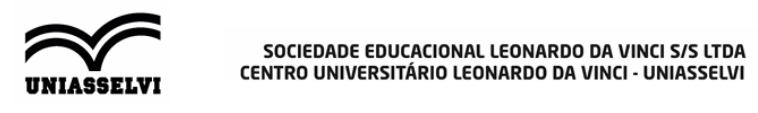

**Acadêmicos:** 


* Cíntia Nunes Schindel (3091094)
* Isaac Gondim Geraldo (3112904)
* Gustavo Barreto de Souza (3340259)
* Rafael Ferreira Martins (3411473)
* Rodrigo Raitz de Aquino (3073320)

# Projeto II - Futuro dos Dados e Aplicação de Big Data

###Principais termos:
###PROCESSAMENTO DE LINGUAGEM NATURAL / INTELIGÊNCIA ARTIFICIAL / MACHINE LEARNING / UNIASSELVI 

## Etapa I 

###Descrição do tema


O Twitter é um local onde frequentemente os usuários se expressam e documentam os ocorridos do seu dia a dia, escrevem avaliações dos mais diversos assuntos e interagem sobre opiniões e acontecimentos em evidência. 
Devido a sua popularidade, é a rede social preferida pela comunidade acadêmica para utilizar como objeto de análise nos mais diversos contextos e, neste projeto, elegemos o Twitter como base de dados na premissa de aplicar técnicas de Machine Learning, Processamento de Linguagem Natural, Inteligência Artificial para medir e rotular opinião pública expressa no Twitter em relação ao tema Uniasselvi.  
Ou seja, o projeto a seguir visa abordar a coleta, a rotulação e preparação de uma base de dados de tweets que contêm a palavra "Uniasselvi" para observar os sentimentos dos usuários acerca do centro universitário e as saídas obtidas não possuem relação com posicionamento ou crítica à Uniasselvi por parte dos integrantes deste projeto.


###Objetivo
Estabelecido o Twitter como a base de dados, sendo os comentários dos usuários chamados de “tweets” objetiva-se neste projeto efetuar a coleta para que seja realizado um pré-processamento preparando a classificação dos “tweets” e suas conotações. Ou seja,  se o sentimento passado por aquele “tweet” poderia ser positivo, negativo ou neutro. Então, com o uso de ”machine learning” e da técnica de Processamento de Linguagem Natural (PLN), iremos treinar um modelo que se comporte como um classificador de “tweets” acerca do tema de busca Uniasselvi. 
Após o treinamento, poderemos utilizar este modelo que foi treinado em uma base com “tweets” rotulados para assim poder categorizar nossos “tweets” criando um rótulo de classificação de sentimento dos 'tweets' do “dataset”. 

### Especificação Técnica

Para a realização deste projeto, optamos em criar nosso próprio dataset, através de uma biblioteca disponível na linguagem Python chamada Snscrape que irá simular o comportamento de uma API para assim efetuarmos a coleta de nossos dados com foco em tweets publicados relacionados à Uniasselvi.

Após a coleta, teremos uma base de dados com os seguintes campos:
- Data_ref Tipo Data: Data da postagem do Tweet.
- Tweet_id Tipo texto: ID daquele Tweet.
- Tweet_url Tipo texto: Url daquele Tweet.
- Tweet_user Tipo texto: Usuário que escreveu o Tweet.
- Tweet_hashtags 	Tipo texto: Hashtag utilizada naquele Tweet caso houver.
- Tweet Tipo texto: Tweet em forma de texto.
- Likes Tipo Inteiro: Quantidade de likes ou curtidas que aquele Tweet recebeu 
- Sentimento Tipo texto: Campo que será incluso ao fim do projeto pelo classificador.

Para efetuarmos a rotulação dos Tweets treinaremos o modelo em uma base classificada, utilizando como principal algoritmo de Machine Learning o Naive Bayes MultinomialNB.
Com os dados rotulados será realizada a etapa de pré-processamento dos dados utilizando técnicas de processamento de linguagem natural. Tendo a base tratada será feita a divisão de treino e teste e avaliação utilizando o classification_report do pacote Scikit-learn. E por fim o treino do modelo.


Link para acessar a base bruta:
* https://github.com/Gustavogrungekk/uniasselvi_project_raw_tweets/blob/main/raw_tweets/twitter_data_bronze.parquet


### Arquitetura do Projeto

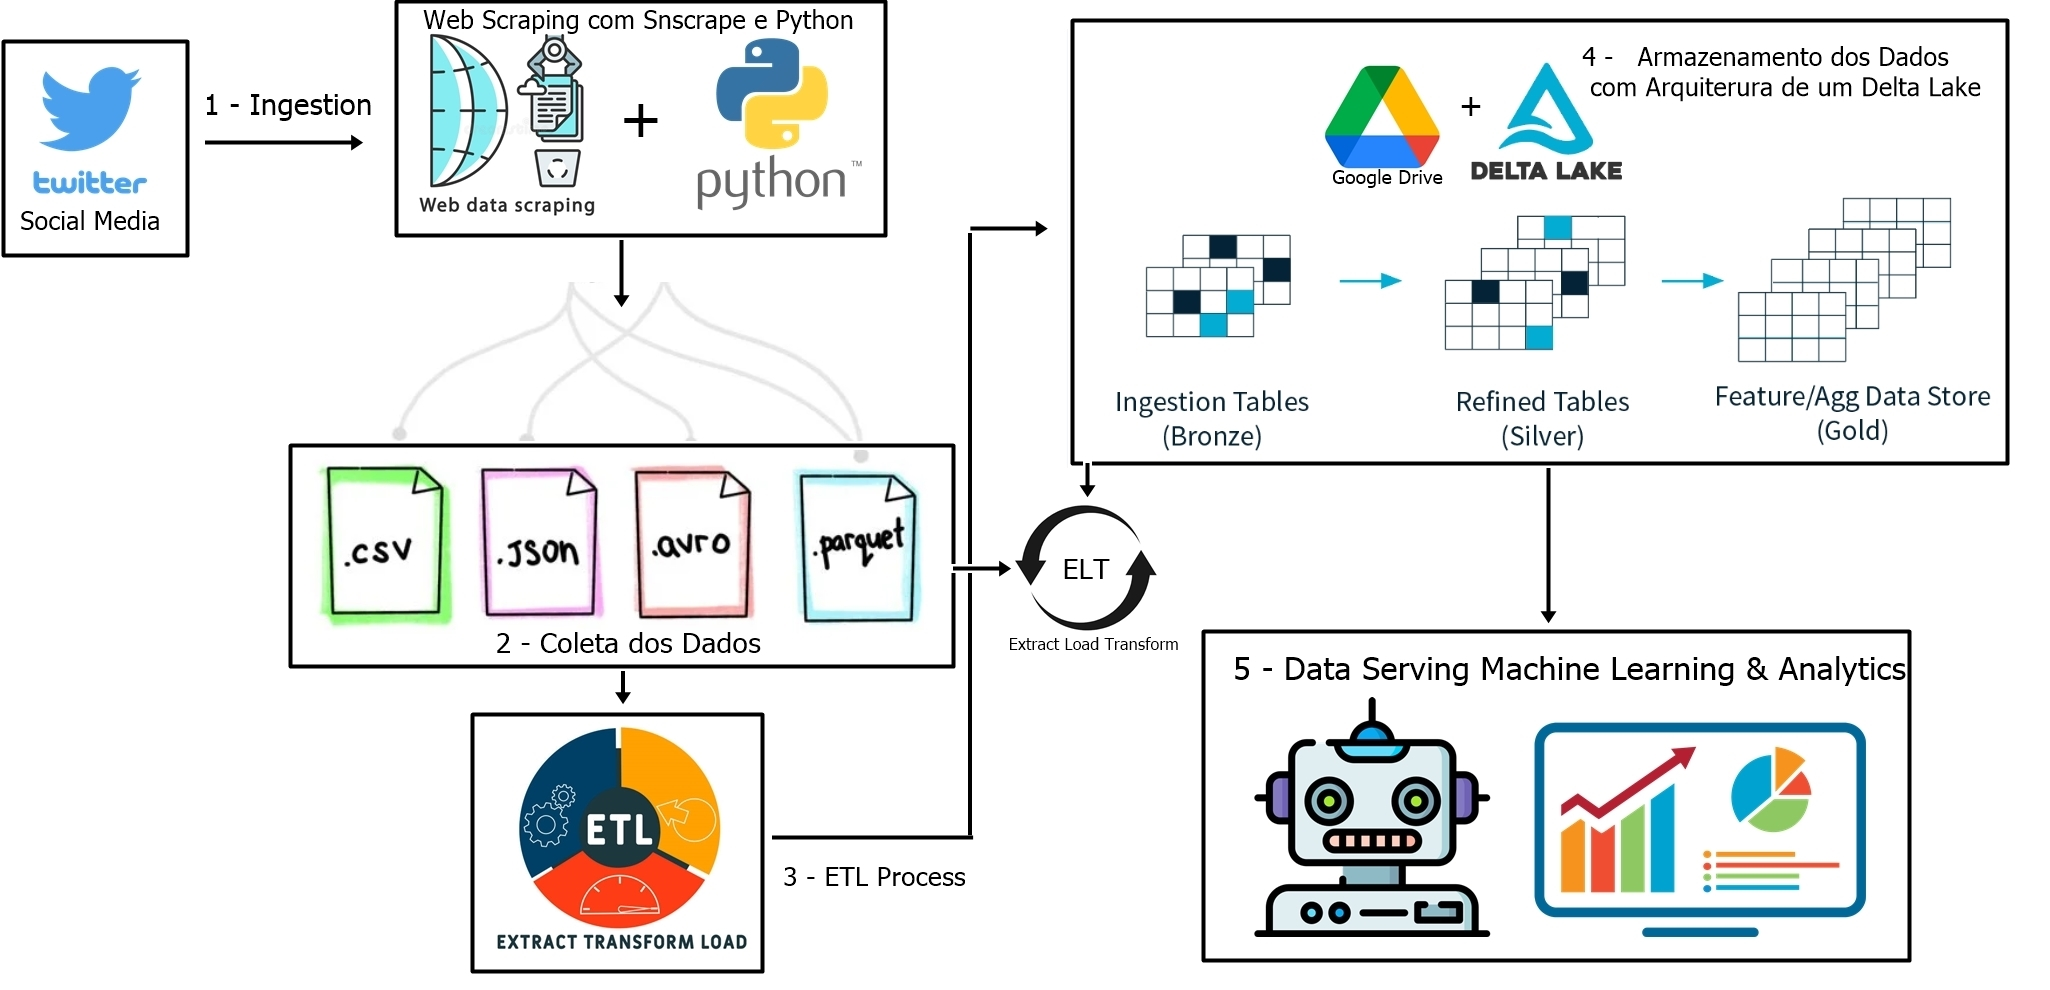

In [ ]:
# IMPORTS RUN IT FIRST
!pip install pyspark
!pip install snscrape
!pip install unidecode
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.regression import *
from pyspark.ml.classification import *
from pyspark.ml.clustering import *
from pyspark.ml.linalg import *
from pyspark.ml.feature import *
from pyspark.sql import functions as F # In case I overwrite col 
from pyspark.sql import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import snscrape.modules.twitter as sntwitter
from unidecode import unidecode
import re, string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

spark = SparkSession.builder.appName('Projeto_uniaselvi_tweets').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Rode somente para baixar conteudos do NLTK
# baixando pacote stopwords 
# nltk.download_shell()

##Etapa II

###PIPLINE INGESTION WITH SNSCRAPE

In [ ]:
a
#=================================================================================================================================================================#
# Description: This script requests data from the Twitter like API library "Snscrape" and stores it in a given location.
# Accordingly we later classifies the tweets based on a model we trained to predict their sentiments.
# Authors: Cíntia Nunes, Isaac Gondim, Rafael Ferreira, Rodrigo Raitz, Gustavo Barreto
# Date: 21/03/2023
# Language: Python 3.9.16
#=================================================================================================================================================================#

# Obtendo os dados com a biblioteca snscrape que simula uma API
buscar = "Uniasselvi"
limit = 10000 # Quantidade de tweets quey iremos trazer
idioma = 'pt' # idioma que iremos filtrar
tweets = [] # Lista para armazenar os tweets
since = '2021-01-01'
until = '2023-04-01'

i = 0
for tweet in sntwitter.TwitterSearchScraper(f'{buscar} since:{since} until:{until}').get_items():
    if i >= limit:
        break
    else:
        if tweet.lang == idioma:
            tweets.append([tweet.date, tweet.id, tweet.url, tweet.username, tweet.hashtags, tweet.rawContent, tweet.likeCount])
    i += 1
    
pd_df = pd.DataFrame(data=tweets,
                     columns=['data_ref', 'tweet_id', 'tweet_url','tweet_user',
                              'tweet_hashatags', 'tweet', 'likes'])

# Enviando os dados para o drive 
location = '/content/drive/MyDrive/data/datalake-bronze/twitter_bronze/twitter_data_bronze.parquet'
pd_df.to_parquet(path=location, compression='snappy')

### ETL

In [ ]:
# Pegando os dados do drive
twitter_bronze = spark.read.format('parquet').load('/content/drive/MyDrive/data/datalake-bronze/twitter_bronze/')
print(f'Quantidade de linhas do nosso dataset: {twitter_bronze.count()}')
twitter_bronze.show()

Quantidade de linhas do nosso dataset: 7199
+-------------------+-------------------+--------------------+--------------+--------------------+--------------------+-----+
|           data_ref|           tweet_id|           tweet_url|    tweet_user|     tweet_hashatags|               tweet|likes|
+-------------------+-------------------+--------------------+--------------+--------------------+--------------------+-----+
|2023-03-31 23:37:16|1641947802631651328|https://twitter.c...|       felairy|                null|se endividar com ...|    0|
|2023-03-31 23:36:56|1641947716992356352|https://twitter.c...|   PedroMottaB|                null|MPT ajuiza acao c...|    0|
|2023-03-31 23:00:45|1641938612802469894|https://twitter.c...|         IERGS|                null|Comenta aqui o qu...|    0|
|2023-03-31 19:29:07|1641885351781318656|https://twitter.c...|    emilydohej|                null|Uniasselvi melhor...|    3|
|2023-03-31 17:06:39|1641849499462008856|https://twitter.c...|    nilamari

In [ ]:
# Primeiro passo limpar o Dataset, removendo pontuacoes emojis hashtags usuarios etc. Do campo

# Funcao para removermos emojis
def remove_emojis(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+")
    return emoji_pattern.sub(r'', string)


# Func para remover links
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text


# Func para remover entidades com como hashtags e @usuarios
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


def remove_pontuacoes(text):
    text = ''.join([i for i in text if i not in frozenset(string.punctuation)])
    return text


# Aplicando as funcoes
twitter_bronze['tweet'] = twitter_bronze['tweet'].apply(strip_links)
twitter_bronze['tweet'] = twitter_bronze['tweet'].apply(strip_all_entities)
twitter_bronze['tweet'] = twitter_bronze['tweet'].apply(remove_emojis)
twitter_bronze['tweet'] = twitter_bronze['tweet'].apply(remove_pontuacoes)

# Enviando os dados semi tratados para o drive 
location = '/content/drive/MyDrive/data/datalake-bronze/twitter_bronze/'
twitter_bronze.to_parquet(path=location, compression='snappy')

### DATA CLEANING AND PREPROCESSING

In [ ]:
# Pegandando os dados o processo de limpeza
location = '/content/drive/MyDrive/data/datalake-bronze/twitter_bronze/'
twitter_bronze = spark.read.format('parquet').load(location)

# Clausula para remover possiveis tweets que contenham Whatsapp atraves de palavras chaves
# assim mantemos somente os comentarios normais, para uma analise mais concreta
# e sem comentarios promocionais.

# Algumas expressoes regulares para filtrarmos
junk = ('/#whatsapp[0-10]+#/|oferta|ofertas|promocoes|eccomerce|vender|varejo|investir|investidor|profissionalizantes')

# Func para retirar qualquer tipo de acentuacoes
unidecode_func = udf(lambda x: unidecode(x).lower())

# Removendo espacos no inicio e no fim das colunas tweet
# Ajustando hashtags para remover acentuacoes 
# Criando condicao de filtro de spam
twitter_bronze = twitter_bronze.withColumn('tweet', lower(trim(col('tweet'))))\
.withColumn('data_ref', to_date(col('data_ref')).cast('date'))\
.withColumnRenamed('tweet_hashatags', 'tweet_hashtags')\
.withColumn("tweet_hashtags", concat_ws(", ", col("tweet_hashtags")))\
.withColumn('tweet_hashtags', unidecode_func('tweet_hashtags'))\
.withColumn('tweet_hashtags', when(col('tweet_hashtags') == '', lit(None)).otherwise(lit(col('tweet_hashtags'))))\
.withColumn('possivel_spam', when(col('tweet').rlike(junk), lit('SPAM')).otherwise(lit('NAO SPAM')))

# Dando uma olhada nos possiveis spams filtrando somente por tweets "classificados" como spam
twitter_bronze.select('tweet', 'possivel_spam').filter(col('possivel_spam') == 'SPAM')#.show(truncate=False, n=30)
# Acredito termos encontrado alguns casos
spam = '''+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|tweet                                                                                                                                                                                                                                                                    |possivel_spam|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|investir em sua formacao sempre e a melhor opcao para construir uma carreira de sucesso e a uniasselvi iergs ajuda voce   aproveite esta chance e faca sua matricula em uma das mais de 170 graduacoes whatsapp 51 3079 8400                                             |SPAM         |
|promocao e valida para graduacao tecnicos e profissionalizantes                                                                                                                                                                                                          |SPAM         |
|com os cursos tecnicos e profissionalizantes da uniasselvi iergs voce tem acesso a uma formacao rapida e de qualidade  inscreva se e aproveite todas as vantagens  whatsapp 51 3079 8400                                                                                 |SPAM         |
|semana do consumidor em comemoracao ao dia do consumidor 15 de marco a uniasselvi preparou uma super oferta para voce  saiba mais e se inscreva aqui todos os cursos com 50 de desconto durantetodo o curso 3 primeiras mensalidades                                     |SPAM         |
|amplie suas chances no mercado de trabalho com os cursos tecnicos e profissionalizantes da uniasselvi iergs  para inscrever se entre em contato pelo whatsapp 51 3079 8400                                                                                               |SPAM         |
|chegou a hora de investir na sua evolucao profissional com a graduacao ead uniasselvi iergs  o proximo passo para garantir seu sucesso e inscrever se  whatsapp 51 3079 8400                                                                                             |SPAM         |
|se voce curte a area da tecnologia e tem pressa de ingressar no mercado de trabalho escolha um dos nossos cursos profissionalizantes  aqui voce se forma em 2 semestres com todos os beneficios do maior ead do brasil  para o mercado escolher voce escolha a uniasselvi|SPAM         |
|chegou a oportunidade ideal para ampliar suas chances profissionais com os cursos tecnicos e profissionalizantes da uniasselvi iergs   inscricoes pelo whatsapp 51 3079 8400                                                                                             |SPAM         |
|para crescer profissionalmente e necessario aprender novas habilidades e uma graduacao pode oferecer isso a voce  a uniasselvi iergs oferta cursos com valores acessiveis que cabem no seu bolso para saber mais envie uma mensagem para nosso whatsapp 51 3079 8400     |SPAM         |
|investir na carreira e de primordial relevancia para enfrentar os desafios do mercado de trabalho  para isso preparamos uma superoferta para voce ingressar na graduacao ead uniasselvi iergs inscreva se  whatsapp 51 3079 8400                                         |SPAM         |
|chegou o momento de voce investir no seu futuro e cursar a tao sonhada graduacao  venha para uniasselvi iergs  whatsapp 51 3079 8400                                                                                                                                     |SPAM         |
|chegou a hora de realizar seu curso tecnico ou profissionalizante  a uniasselvi iergs preparou uma oferta imperdivel para voce ingressar ja faca sua matricula pelo whatsapp 51 3079 8400                                                                                |SPAM         |
|nada esta perdido  a uniasselvi tem mensalidades acessiveis e condicoes imperdiveis te esperando na graduacao presencial e ead pos graduacao e cursos tecnicos e profissionalizantes invista em voce com um preco que cabe no bolso  acesse                              |SPAM         |
|vale a pena os cursos profissionalizantes da uniasselvi                                                                                                                                                                                                                  |SPAM         |
|a uniasselvi iergs oferece cursos tecnicos e profissionalizantes que preparam e ajudam voce a se destacar no mercado de trabalho   whatsapp 51 3079 8400                                                                                                                 |SPAM         |
|a uniasselvi iergs possui varias opcoes de cursos tecnicos ou profissionalizantes ead para voce escolher a que se encaixa melhor no seu futuro profissional   whatsapp 51 3079 8400                                                                                      |SPAM         |
|a uniasselvi iergs possui cursos tecnicos ou profissionalizantes ead com certificacao reconhecida pelo mec e formacao rapida aproveite e matricule se  whatsapp 51 3079 8400                                                                                             |SPAM         |
|chegou o momento para investir em seu futuro profissional  inscreva se ja na pos ead da uniasselvi iergs  whatsapp 51 3079 8400                                                                                                                                          |SPAM         |
|a uniasselvi iergs possui varios cursos tecnicos e profissionalizantes para voce se preparar e mudar sua carreira  inscreva se ja  whatsapp 51 3079 8400                                                                                                                 |SPAM         |
|a uniasselvi iergs oferta diversos cursos tecnicos e profissionalizantes reconhecidos pelo mec para voce garantir a qualificacao profissional ideal  aproveite e inscreva se ja pelo whatsapp 51 3079 8400                                                               |SPAM         |
|a uniasselvi iergs vai te dar uma maozinha para voce poder investir em sua carreira em engenharia ou saude bolsa de estudos ate o fim do curso escolhido e primeira mensalidade em novembro  faca sua inscricao pelo whatsapp 51 3079 8400                               |SPAM         |
|chegou a sua chance de crescer profissionalmente com as formacoes tecnicas e profissionalizantes da uniasselvi iergs  matricule se agora mesmo whatsapp 51 3079 8400                                                                                                     |SPAM         |
|ainda da tempo de realizar o seu sonho venha para uniasselvi polo bauru ofertas especiais para inicio imediato maiores informacoes  14 3234 5002 whatsapp                                                                                                                |SPAM         |
|o ingresso no mercado de trabalho faz parte dos momentos importantes na vida profissional e por isso a uniasselvi iergs oferta uma bolsa de estudos especial para voce fazer sua qualificacao  aproveite e inscreva se ja  whatsapp 51 3079 8400                         |SPAM         |
|rematriculas de 2022 2 na uniasselvi alunos da graduacao tecnico e profissionalizantes ja podem fazer a rematricula para 2022 2 a renovacao acontece automaticamente mediante pagamento da primeira mensalidade do semestre letivo invista na sua carreira               |SPAM         |
|ja estamos na metade do ano e voce ja definiu suas metas profissionais nos da uniasselvi iergs oportunizamos seu crescimento atraves da oferta de bolsa de estudos em todo o curso  entre em contato conosco e saiba mais whatsapp 51 3079 8400                          |SPAM         |
|curso superior em ciencias da religiao passa a ser ofertado na uniasselvi                                                                                                                                                                                                |SPAM         |
|curso superior em ciencias da religiao passa a ser ofertado na uniasselvi censo escolar mostra que ha necessidade de professores na area  leia a noticia completa no site timbo net                                                                                      |SPAM         |
|na uniasselvi iergs temos varios cursos tecnicos e profissionalizantes para voce realizar o seu sonho de entrar para o mercado de trabalho com a melhor qualificacao  saiba mais e inscreva se  whatsapp 51 3079 8400                                                    |SPAM         |
|as ofertas vao ate sexta feira 22 faca sua matricula hoje                                                                                                                                                                                                                |SPAM         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+'''

# # Enviando os dados para a silver
location = '/content/drive/MyDrive/data/datalake-silver/twitter_silver'
twitter_bronze.write.mode('overwrite').parquet(location)

##Etapa III

### MACHINE LEARNING NLP

A ideia proposta nesta parte sera utilizar um dataset com tweets classificados como (Positivo, Negativo, Neutro) pois assim conseguiremos treinar um modelo de NLP e tirar as métricas de acurácia do mesmo. Após isso utilizaremos este modelo já treinando em uma base rotulada em nossa base de dados que foi coletada para assim podermos fazer a rotulação dos sentimentos dos usuários em cima daqueles tweets propostos por eles. Optei por utilizar o MultinomialNB por se famoso em resolver casos de NLP.

O classificador multinomial Naive Bayes é adequado para classificação com características discretas (por exemplo, contagem de palavras para classificação de texto). A distribuição multinomial normalmente requer contagens de características inteiras. No entanto, na prática, contagens fracionárias como tf-idf também podem funcionar.

link: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Para um processamento de classificacao dos tweets utilizarei o NLTK site: https://www.nltk.org/

O Natural Language Toolkit (NLTK) é uma plataforma usada para construir programas Python que trabalham com dados de linguagem humana para aplicação em processamento estatístico de linguagem natural (NLP). Ele contém bibliotecas de processamento de texto para tokenização, análise, classificação, derivação, marcação e raciocínio semântico.


* Dataset com tweets classificados link: https://www.kaggle.com/datasets/augustop/portuguese-tweets-for-sentiment-analysis

Sentiment:
- Negative label: 0
- Positive label: 1
- Neutral label: 2

1    31813
0    31793
2    29999
Name: sentiment, dtype: int64

Quantidade de linhas com qual iremos trabalhar: 93605



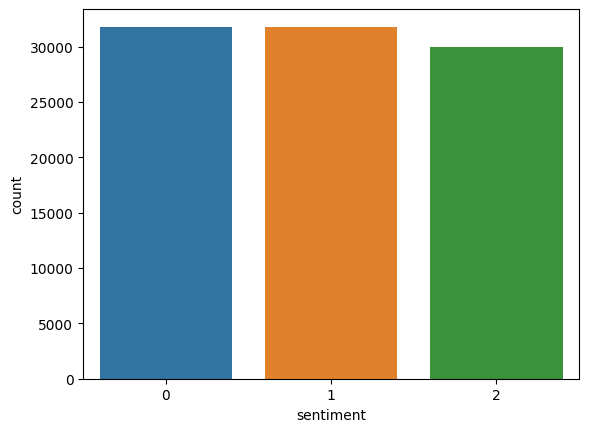

In [ ]:
# Mais pre-processamento dos dados
df = pd.read_csv('/content/drive/MyDrive/data/tweets_classificados/Train3Classes.csv',
                 on_bad_lines='skip', sep=';', encoding='utf-8')

# Selecionando somente os campos quer iremos utilizar
df = df[['tweet_text', 'sentiment']]

# Aplicando as funcoes de pre-processamento que utilizamos na parte de ingestao em cima deste dataset
df['tweet_text'] = df['tweet_text'].apply(strip_links)
df['tweet_text'] = df['tweet_text'].apply(strip_all_entities)
df['tweet_text'] = df['tweet_text'].apply(remove_emojis)
df['tweet_text'] = df['tweet_text'].apply(str.lower)
df = df.drop_duplicates() # Removendo linhas duplicadas


# Seus rótulos de sentimento foram transformados da seguinte forma:
# Rótulo negativo: 0
# Rótulo positivo: 1
# Rótulo neutro: 2
# Visualizando a quantidade de classificacoes que possuimos na base
print(df['sentiment'].value_counts())
print()
print(f'Quantidade de linhas com qual iremos trabalhar: {len(df)}')
print()
# Acredito termos um numero consideravel para treinarmos um modelo
sns.countplot(x='sentiment', data=df)
plt.show()

##### Removendo stop-words 
O que são palavras de parada com exemplo?
As palavras de parada são um conjunto de palavras comumente usadas em um idioma.
Exemplos de stopwords em inglês são “ao,” “aquela,” “este,” “estão,” etc.
Stop words são comumente usadas em Text Mining e Natural Language Processing (NLP)
para eliminar palavras que são tão amplamente usadas que carregam muito pouca informação útil.

In [ ]:
print(f'Exemplos de stop-words {list(stopwords.words("portuguese"))[1:20]}') # Visualizando algumas stop words do pacote NLTK
print('')
print(f'Ao todo o pacote nos traz um total de {len(list(stopwords.words("portuguese")))} stop-words na língua portuguesa.')

Exemplos de stop-words ['à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele']

Ao todo o pacote nos traz um total de 207 stop-words na língua portuguesa.


In [ ]:
# Criando nova funcao de processamento com foco no modelo para vetorizarmos

def processamento_texto(txt):
    '''
    1. remove pontuacoes
    2. remove stopwords
    3. retorna uma lista de palavras tratadas
    '''
    nopunc = [x for x in txt if x not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('portuguese')]

#### Vetorização
Atualmente, temos as mensagens como listas de tokens (também conhecidas como [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) e agora precisamos converter cada uma dessas mensagens em um vetor com o qual os modelos de algoritmo do SciKit Learn possam trabalhar.

Agora converteremos cada mensagem, representada como uma lista de tokens (lemas) acima, em um vetor que os modelos de aprendizado de máquina possam entender.

Faremos isso em três etapas usando o modelo bag-of-words:

1. Conte quantas vezes uma palavra ocorre em cada mensagem (conhecida como frequência de termo)

2. Pesar as contagens, para que os tokens frequentes tenham um peso menor (frequência inversa do documento)

3. Normalize os vetores para comprimento unitário, para abstrair do comprimento do texto original (norma L2)

Cada vetor terá tantas dimensões quantas forem as palavras únicas. Primeiro usaremos o **CountVectorizer** do SciKit Learn. Este modelo converterá uma coleção de documentos de texto em uma matriz de contagem de tokens.

Podemos imaginar isso como uma matriz bidimensional. Onde a dimensão 1 é o vocabulário inteiro (1 linha por palavra) e a outra dimensão são os documentos reais, neste caso uma coluna por mensagem de texto.

Por exemplo:

<table border = “1“>
<tr>
<th></th> <th>Mensagem 1</th> <th>Mensagem 2</th> <th>...</th> <th>Mensagem N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Como há tantas mensagens, podemos esperar muitas contagens zero para a presença dessa palavra naquele documento. Por causa disso, o SciKit Learn produzirá uma [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [ ]:
# Criando uma bag of words de nossos tweets e fit() para ajustar o modelo aos dados que estamos passando
# Demora um pouco para rodar!
bow_transformador = CountVectorizer(analyzer=processamento_texto).fit(df['tweet_text'])x

In [ ]:
print(f'Total de vocabularios: {len(bow_transformador.vocabulary_)}')

# O método transform() aplica os parâmetros calculados para padronizar os dados
mensagens = bow_transformador.transform(df['tweet_text'])x

Total de vocabularios: 65261


In [ ]:
#Criando nosso modelo com o MultinomialNB()
tfidf = TfidfTransformer().fit(mensagens)
mensagens_tfidf = tfidf.transform(mensagens)
detector_sentimento = MultinomialNB().fit(mensagens_tfidf, df['sentiment'])


# Train test split para podermos tirar as metricas do modelo
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(df['tweet_text'],
                                                                df['sentiment'],
                                                                test_size=0.3)

Como somente no final do modelo que fizemos o train/test/split o que não é recomendável pois
sempre queremos ter uma base de teste para podermos avaliar nosso modelo, e checar o desempenho do mesmo. Neste caso seria necessário refazer toda a parte desde a bag of words até o treinamento do modelo com o MultinomialNB. Porém este é um processo tão comum que o próprio sklearn desenvolveu um pipeline para isso, assim somente passamos a ordem de como iremos receber o dado. Inclusive dentro do pipeline podemos passar diversos modelos.

In [ ]:
# Utilizando um pipeline para treinarmos o modelo
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=processamento_texto)),
    ('tfidf', TfidfTransformer()),
    ('classificador', MultinomialNB())
])

# Pode demorar um para rodar
pipeline.fit(msg_train, label_train)x

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function processamento_texto at 0x7fcad8334d30>)),
                ('tfidf', TfidfTransformer()),
                ('classificador', MultinomialNB())])

Acredito ser um bom classificador com 78% de acurácia desde que não precisei fazer nenhuma alteração ou tuning de parâmetros. Podemos ver que ele consegue detectar positivos e negativos com acurácia de 74% e 70% e neutros com 90%. E uma das métricas mais importantes o f1-score que mede a precisão geral do classificador também atingiu resultados excepcionais.

In [ ]:
# Observando as metetricas de nosso modelo
predictions = pipeline.predict(msg_test)
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      9577
           1       0.70      0.71      0.70      9548
           2       0.90      0.87      0.88      8957

    accuracy                           0.78     28082
   macro avg       0.78      0.78      0.78     28082
weighted avg       0.78      0.78      0.78     28082



In [ ]:
# Função de detecção de emoções 
def classificador(tweet):
    tweet = [tweet]
    if pipeline.predict(tweet) == 1:
        return 'POSITIVO'
    elif pipeline.predict(tweet) == 2:
        return 'NEUTRO'
    else:
        return 'NEGATIVO'


# testando
tweet1 = 'foi um dia maravilhoso gostei muito daquele lugar'
tweet2 = 'quero que se dane pior lugar do mundo nunca irei recomendar'
tweet3 = 'congresso aprova lei que pode permitir novas regras para a cnh'   

print(f'{tweet1}. Label: {classificador(tweet1)}')
print(f'{tweet2}. Label: {classificador(tweet2)}')
print(f'{tweet3}. Label: {classificador(tweet3)}')

foi um dia maravilhoso gostei muito daquele lugar. Label: POSITIVO
quero que se dane pior lugar do mundo nunca irei recomendar. Label: NEGATIVO
congresso aprova lei que pode permitir novas regras para a cnh. Label: NEUTRO


### MODEL DEPLOYMENT EM CIMA DA BASE QUE FOI COLETADA

In [ ]:
# lendo o arquivo da silver
location = '/content/drive/MyDrive/data/datalake-silver/twitter_silver/'
twitter_silver = spark.read.format('parquet').load(location)

# Filtrando por um dataset sem spams
twitter_silver = twitter_silver.filter(upper(col('possivel_spam')) != 'SPAM')

# Selecionando somente os campos que iremos utilizar na etapa de Machine Learning
twitter_silver = twitter_silver.select('data_ref',
                     'tweet_id',
                     'tweet_user',
                     'tweet_hashtags',
                     'tweet',
                     'likes')
print(f'Quantidade de linhas de nosso dataset: {twitter_silver.count()}')
print()
twitter_silver.printSchema()

Quantidade de linhas de nosso dataset: 7106

root
 |-- data_ref: date (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- tweet_user: string (nullable = true)
 |-- tweet_hashtags: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: long (nullable = true)



In [ ]:
twitter_silver.show()

+----------+-------------------+--------------+--------------------+--------------------+-----+
|  data_ref|           tweet_id|    tweet_user|      tweet_hashtags|               tweet|likes|
+----------+-------------------+--------------+--------------------+--------------------+-----+
|2023-03-31|1641947802631651328|       felairy|                null|se endividar com ...|    0|
|2023-03-31|1641947716992356352|   PedroMottaB|                null|mpt ajuiza acao c...|    0|
|2023-03-31|1641938612802469894|         IERGS|                null|comenta aqui o qu...|    0|
|2023-03-31|1641885351781318656|    emilydohej|                null|uniasselvi melhor...|    3|
|2023-03-31|1641849499462008856|    nilamaria_|                null|muito arrependida...|    0|
|2023-03-31|1641846524756865025|   Stecabreira|                null|juro que so vou s...|    1|
|2023-03-31|1641835230993559552|     laarissmp|                null|amiga tu lembra f...|    0|
|2023-03-31|1641825712339296259|  Uniass

In [ ]:
# Aplicando a função para detectarmos as emoções da base de dados 

# Convertendo a função para UDF
sentiment_detector = udf(lambda x: classificador(x), StringType())
capitalizer = udf(lambda x: str(x).capitalize())

twitter_silver = twitter_silver.withColumn('sentimento', sentiment_detector(col('tweet')))\
.withColumn('tweet', capitalizer(col('tweet')))

# Enviando os dados para a gold prontos para o consumo
location = '/content/drive/MyDrive/data/datalake-gold/twitter_gold/'
twitter_silver.write.mode('overwrite').parquet(location)

# Header do dataset
twitter_silver.show()

+----------+-------------------+--------------+--------------------+--------------------+-----+----------+
|  data_ref|           tweet_id|    tweet_user|      tweet_hashtags|               tweet|likes|sentimento|
+----------+-------------------+--------------+--------------------+--------------------+-----+----------+
|2023-03-31|1641947802631651328|       felairy|                null|Se endividar com ...|    0|  NEGATIVO|
|2023-03-31|1641947716992356352|   PedroMottaB|                null|Mpt ajuiza acao c...|    0|    NEUTRO|
|2023-03-31|1641938612802469894|         IERGS|                null|Comenta aqui o qu...|    0|  POSITIVO|
|2023-03-31|1641885351781318656|    emilydohej|                null|Uniasselvi melhor...|    3|  NEGATIVO|
|2023-03-31|1641849499462008856|    nilamaria_|                null|Muito arrependida...|    0|  NEGATIVO|
|2023-03-31|1641846524756865025|   Stecabreira|                null|Juro que so vou s...|    1|  NEGATIVO|
|2023-03-31|1641835230993559552|     

### ANÁLISE EXPLORATÓRIA DOS RESULTADOS OBTIDOS

- Total de todos os sentimentos
- Quais hashtags foram mais utilizadas TOP 20
- Quais tweets tiveram maior quantidade de likes TOP 20
- Palavras mais frequentes utilizadas nos tweets TOP 20
- Total de sentimentos por mês

In [ ]:
# lendo os dados da gold
location = '/content/drive/MyDrive/data/datalake-gold/twitter_gold/'
df = spark.read.format('parquet').load(location)

# Forma final de nosso dataset
df.show()

+----------+-------------------+--------------+--------------------+--------------------+-----+----------+
|  data_ref|           tweet_id|    tweet_user|      tweet_hashtags|               tweet|likes|sentimento|
+----------+-------------------+--------------+--------------------+--------------------+-----+----------+
|2023-03-31|1641947802631651328|       felairy|                null|Se endividar com ...|    0|  NEGATIVO|
|2023-03-31|1641947716992356352|   PedroMottaB|                null|Mpt ajuiza acao c...|    0|    NEUTRO|
|2023-03-31|1641938612802469894|         IERGS|                null|Comenta aqui o qu...|    0|  POSITIVO|
|2023-03-31|1641885351781318656|    emilydohej|                null|Uniasselvi melhor...|    3|  NEGATIVO|
|2023-03-31|1641849499462008856|    nilamaria_|                null|Muito arrependida...|    0|  NEGATIVO|
|2023-03-31|1641846524756865025|   Stecabreira|                null|Juro que so vou s...|    1|  NEGATIVO|
|2023-03-31|1641835230993559552|     

In [ ]:
# Contagem total dos sentimentos classificados
count_sentimentos = df.groupBy('sentimento').agg(count('sentimento').alias('total_sentimento')).orderBy('sentimento', ascending=False)

# Contagem total das hashtags utilizadas TOP 20
freq_hashs = df.withColumn('hashtag', explode(split(trim(col('tweet_hashtags')), ',')))\
.withColumn('hashtag', trim(col('hashtag')))\
.withColumn('hashtag', capitalizer(col('hashtag')))\
.groupBy('hashtag').agg(count('hashtag').alias('hash_count'))\
.orderBy('hash_count', ascending=False)

# Filtrando tweets com maior quantidades de likes TOP 10
top_likes = df.groupBy('tweet_user','tweet').agg(sum('likes').alias('top_likes'))\
.orderBy('top_likes', ascending=False)

# Palavras mais frequentes utilizadas nos tweets TOP 20
# Filtrando por somente palavras com mais de 5 digitos
# Filtrando por tweets que nao são digitos 
freq_tweets = df.withColumn('freq_tweets', explode(split(lower(trim(col('tweet'))), ' ')))\
.groupBy('freq_tweets')\
.agg(count('freq_tweets').alias('tweet_count'))\
.sort('tweet_count', ascending=False)\
.filter(length(col('freq_tweets')) > 5)\
.filter(col('freq_tweets').rlike('\D+')).orderBy('tweet_count', ascending=False)

# Total de sentimentos por mês
sentimentos_mes = df.withColumn('mes_truncado' ,to_date(date_trunc('month' ,'data_ref')))\
.groupBy('mes_truncado', 'sentimento').agg(count('sentimento').alias('count_sentimento'))\
.orderBy('mes_truncado')

### Total dos sentimentos classificados

In [ ]:
fig = px.bar(count_sentimentos.toPandas(), x='sentimento',
             y='total_sentimento', color='sentimento',
             width=1200, height=500)

fig.update_layout(title_text = 'Total de Emoções Classificadas', title_x = 0.5)
fig.show()

### Quais hashtags foram mais utilizadas TOP 20

In [ ]:
fig = px.pie(freq_hashs.toPandas().head(20), values='hash_count',
             names='hashtag',title = 'Top 20 Hashtags Mais Frequentes',
             width=950, height=650,)

fig.update_traces(textposition='inside', textinfo='percent+label',
                  textfont_size=20)
fig.show()

### TOP 20 Com Maior Quantidade de Likes

In [ ]:
# Tweets com maior quantidade de likes TOP 20
fig = go.Figure(data=[go.Table(
    header=dict(values=list(top_likes.toPandas()),
                fill_color='white',
                align='left'),
    cells=dict(values=[top_likes.toPandas().tweet_user.head(20),
                       top_likes.toPandas().tweet.head(20),
                       top_likes.toPandas().top_likes.head(20)],
               fill_color='white',
               align='left'),)
])

fig.show()

### TOP 20 Palavras Mais Frequentes Utilizadas nos Tweets

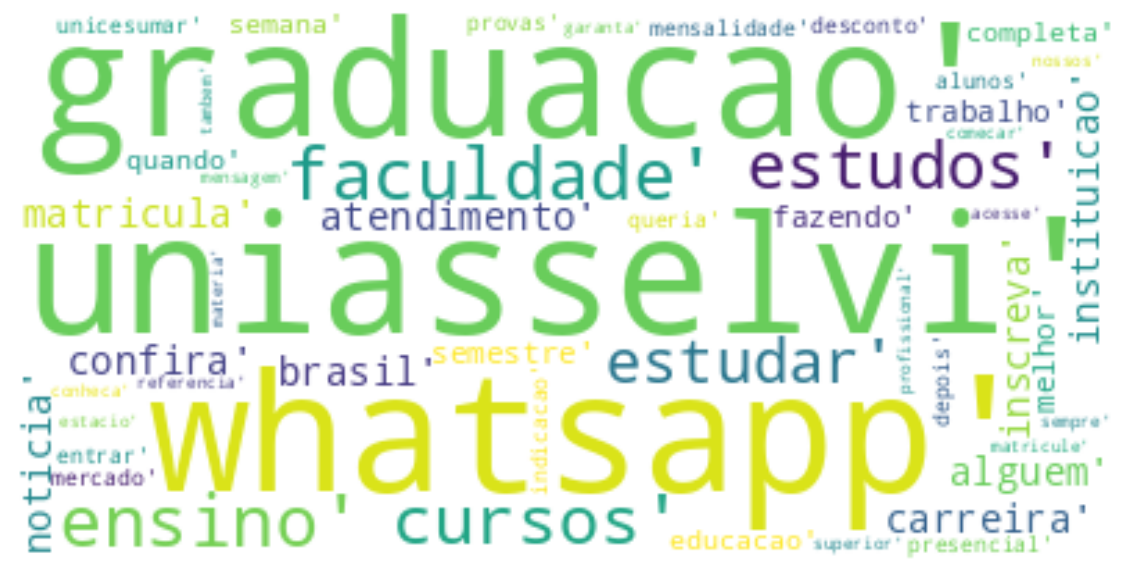

In [ ]:
text = freq_tweets.toPandas().head(50).freq_tweets.values
wordcloud = WordCloud(background_color='white').generate(str(text))
plt.figure(figsize=(12,6), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Total de Sentimentos Classificados por Mês

In [ ]:
fig = px.bar(sentimentos_mes.toPandas(), x='mes_truncado',
             y='count_sentimento', color='sentimento',
             width=1400, height=600)

fig.update_layout(title_text = 'Total de Emoções Classificadas Mensalmente Período 2021/01/01 - 2023-03-31', title_x = 0.5)
fig.show()

# CONCLUSÕES FINAIS

Podemos concluir que nosso modelo obteve uma performance consideravelmente boa. Pois em um cenário de caso real um modelo que consegue atingir 70% ou mais em acurácia e com um bom F1-Score é considerado um modelo muito bom. Como nosso projeto foi desenvolvido com fins acadêmicos acredito não haver a necessidade de tuning ou validação cruzada para atingirmos maiores porcentagens de acurácia, pois já atingimos nosso objetivo que foi classificar os sentimentos de tweets relacionados a Uniasselvi através de uma coleta única que fizemos através da biblioteca em Python snscrape que funciona como uma ferramenta de raspagem consiste na extração de dados da web de alguma rede social ou site.

#### Exemplo Twitter antes e depois de tratado

In [ ]:
ids = ['1050785368902131713',  '1050785125770948608', '1050785006522642433']

# Antes do tratamento
location_raw = ('/content/drive/MyDrive/data/tweets_classificados/Train3Classes.csv')

print(f'{"=" * 50} Não Tratado {"=" * 50}')
raw_tweets = spark.read.format('csv')\
.option('header', True).option('delimiter', ';')\
.load(location_raw)\
.filter(col('id').isin(ids)).select('id', 'tweet_text')\
.show(truncate=False)


# UDF das funções que defininmos 
strips_link = udf(lambda x: strip_links(x))
strip_entities = udf(lambda x: strip_all_entities(x))
emoji_remover = udf(lambda x: remove_emojis(x))

# Depois do tratamento
print(f'{"=" * 50} Tratado {"=" * 50}')
treated_tweets = spark.read.format('csv')\
.option('header', True).option('delimiter', ';')\
.load(location_raw)\
.filter(col('id').isin(ids))\
.withColumn('tweet_text', strips_link(col('tweet_text')))\
.withColumn('tweet_text', strip_entities(col('tweet_text')))\
.withColumn('tweet_text', emoji_remover(col('tweet_text')))\
.withColumn('tweet_text', lower(col('tweet_text')))\
.select('id', 'tweet_text')\
.show(truncate=False)

================================================== Não Tratado ==================================================
+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                 |tweet_text                                                                                                                                                                                         |
+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1050785368902131713|Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9|
|1050785125770